In [1]:
!pip install imutils

  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=fc33937c922cd100ec76361390401e4235cb9664da374530a6275e50a15e488d
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam,Adamax
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import shutil
import random
import cv2
import argparse
import os
import pandas as pd

In [3]:
!gdown --id 1bFrktIYGOp9cU7o6QBL8cv2QGToONh-W
!gdown --id 1uCB5XydEqICQnGCWRWc2xXCg0exLhjc_

/bin/bash: gdown: command not found
/bin/bash: gdown: command not found


In [4]:
! conda install openpyxl -y

Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - openpyxl


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2021.10.8          |   py37h89c1867_1         145 KB  conda-forge
    conda-4.11.0               |   py37h89c1867_0        16.9 MB  conda-forge
    et_xmlfile-1.0.1           |          py_1001          11 KB  conda-forge
    openpyxl-3.0.9             |     pyhd8ed1ab_0         153 KB  conda-forge
    -------

In [5]:
datanom = pd.read_excel('../input/normal/Normal.metadata.xlsx')
datanom['FILE NAME'][0]
datacov = pd.read_excel('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID.metadata.xlsx')
datacov['FILE NAME'][0]

'COVID-1'

In [6]:
import os
output = '/kaggle/working/data/'
try:
    os.mkdir(output)
    os.mkdir(output+'/Normal')
    os.mkdir(output+'/COVID')

except Exception as e :
    print(e)

In [7]:
i=[]
for j in range(len(datanom)):
  i.append(j)
datanom_clean,_,datanom_id,_ = train_test_split(datanom,i , train_size = 1500,random_state = 42)
i=[]
for j in range(len(datacov)):
  i.append(j)
datacov_clean,_,datacov_id,_ = train_test_split(datacov,i , train_size = 1500,random_state = 42)

In [8]:
for i in datanom_id: #1500
    dest = './data/Normal/'+datanom['FILE NAME'][i]+'.png'
    src = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/'+datanom_clean['FILE NAME'][i]+'.png' #//content/gdrive/My Drive/data_set/all/
    shutil.copyfile(src, dest)
for i in datacov_id: #1500
    dest = './data/COVID/'+datacov['FILE NAME'][i]+'.png'
    src = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/'+datacov_clean['FILE NAME'][i]+'.png' #//content/gdrive/My Drive/data_set/all/
    shutil.copyfile(src, dest)
print('ok')

ok


In [9]:
dataset_path='./data'
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset_path))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)
print("[INFO] Images successfully loaded")

[INFO] loading images...
[INFO] Images successfully loaded


In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, Sequential
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,AveragePooling2D
from tensorflow.keras.optimizers import Adam,Adamax
from tensorflow.keras.layers import Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from keras.models import Model
from keras.layers import Flatten, Dense
from keras.applications.vgg16 import VGG16
from tensorflow import keras
import matplotlib.cm as cm
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers.experimental.preprocessing import Resizing, Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time


In [11]:
# Now we will create a One-Hot encoding to the list of labels to make the classfication
# integer encode
lb_encoder = LabelEncoder()
labels = lb_encoder.fit_transform(labels)
labels = to_categorical(labels)


# Split the data into training and testing using the 80% of training and 20% to testing
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2, stratify = labels,random_state = 42)


# Set the image augmentation of the training data
trainAug = ImageDataGenerator(rotation_range= 15, fill_mode='nearest')

In [12]:
INIT_LR = 1e-3
EPOCHS = 100
BS = 8
base_model = VGG16(weights = 'imagenet', include_top=False, input_tensor=Input(shape=(224,224,3)))
headmodel = base_model.output
headmodel = AveragePooling2D(pool_size =(4, 4))(headmodel)
headmodel = Flatten(name ='Flatten')(headmodel)
headmodel = Dense(64, activation = 'relu')(headmodel)
headmodel = Dropout(0.5)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = base_model.input, outputs = headmodel)

for layers in base_model.layers:
    layers.trainable = False


opt = Adam(lr = INIT_LR, decay = INIT_LR/EPOCHS)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])


2021-12-06 08:22:20.045245: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-06 08:22:20.139216: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-06 08:22:20.139911: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-06 08:22:20.141341: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 1s 0us/step


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [14]:
with tf.device('/gpu:0'):
    print("Training the model with gpu . . .")
    hist = model.fit_generator(trainAug.flow(X_train, y_train, batch_size = BS),steps_per_epoch=len(X_train) // BS, validation_data=(X_test, y_test), validation_steps=len(X_test) // BS, epochs=100)


Training the model with gpu . . .


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-12-06 08:22:25.556065: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2021-12-06 08:22:27.320708: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


300/300 [==============================] - ETA: 0s - loss: 0.5736 - accuracy: 0.7079

2021-12-06 08:22:58.025745: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 361267200 exceeds 10% of free system memory.
2021-12-06 08:22:58.505670: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 361267200 exceeds 10% of free system memory.


300/300 [==============================] - 36s 96ms/step - loss: 0.5736 - accuracy: 0.7079 - val_loss: 0.5131 - val_accuracy: 0.7500
Epoch 2/100
300/300 [==============================] - 27s 91ms/step - loss: 0.5029 - accuracy: 0.7721 - val_loss: 0.4638 - val_accuracy: 0.7900
Epoch 3/100
300/300 [==============================] - 27s 91ms/step - loss: 0.4651 - accuracy: 0.7892 - val_loss: 0.4413 - val_accuracy: 0.7983
Epoch 4/100
300/300 [==============================] - 27s 90ms/step - loss: 0.4512 - accuracy: 0.7929 - val_loss: 0.4061 - val_accuracy: 0.8167
Epoch 5/100
300/300 [==============================] - 26s 87ms/step - loss: 0.4235 - accuracy: 0.8125 - val_loss: 0.3938 - val_accuracy: 0.8300
Epoch 6/100
300/300 [==============================] - 27s 89ms/step - loss: 0.4134 - accuracy: 0.8087 - val_loss: 0.4004 - val_accuracy: 0.8167
Epoch 7/100
300/300 [==============================] - 27s 90ms/step - loss: 0.4041 - accuracy: 0.8238 - val_loss: 0.3843 - val_accuracy: 0.83

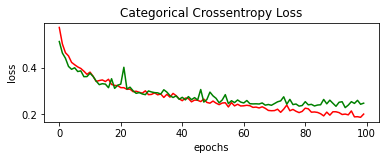

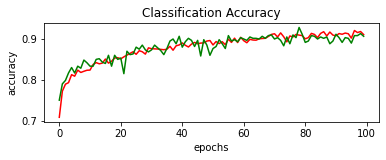

In [15]:
plt.subplot(211)
plt.title('Categorical Crossentropy Loss')
plt.plot(hist.history['loss'], color ='red', label='train')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(hist.history['val_loss'], color ='green', label='val')

plt.show()

plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(hist.history['accuracy'], color='red', label='train')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(hist.history['val_accuracy'], color='green', label='test')

plt.show()

In [16]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(X_test, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(y_test.argmax(axis=1), predIdxs, target_names=lb_encoder.classes_))

[INFO] evaluating network...


2021-12-06 09:14:05.517963: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 361267200 exceeds 10% of free system memory.
2021-12-06 09:14:06.008510: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 361267200 exceeds 10% of free system memory.


              precision    recall  f1-score   support

       COVID       0.91      0.90      0.91       300
      Normal       0.90      0.91      0.91       300

    accuracy                           0.91       600
   macro avg       0.91      0.91      0.91       600
weighted avg       0.91      0.91      0.91       600



In [17]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(y_test.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the accuracy, sensitivity, and specificity of the test
print("accuracy: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

accuracy: 0.9067
sensitivity: 0.9033
specificity: 0.9100


In [18]:
model.save('./')
import pandas as pd
hist_df = pd.DataFrame(hist.history) 
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

2021-12-06 09:14:42.836374: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [19]:
model = tf.keras.models.load_model('../input/normal/vgg16.h5')

In [20]:
import itertools

def plot_confusion_matrix(cm, classes,
                           normalize=False,
                           title='Confusion matrix',
                           cmap=plt.cm.Blues):
     """
     This function prints and plots the confusion matrix.
     Normalization can be applied by setting `normalize=True`.
     """
     
     plt.imshow(cm, interpolation='nearest', cmap=cmap)
     plt.title(title)
     plt.colorbar()
     tick_marks = np.arange(len(classes))
     plt.xticks(tick_marks, classes, rotation=45)
     plt.yticks(tick_marks, classes)

     if normalize:
         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
         print("Normalized confusion matrix")
     else:
         print('Confusion matrix, without normalization')

     print(cm)

     thresh = cm.max() / 2.
     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
         plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

     plt.tight_layout()
     plt.ylabel('True label')
     plt.xlabel('Predicted label')
     plt.show()

In [21]:
def score(model,shape):
  predict = model.predict(X_test, batch_size=BS)
  predict = np.argmax(predict, axis=1)
  cm = confusion_matrix(y_test.argmax(axis=1), predict)
  cm_plot_labels = ['COVID-19','Normal']
  plot_confusion_matrix(cm, classes=cm_plot_labels, title='Confusion Matrix') 
  accuracy = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
  recall = (cm[0][0])/(cm[0][0]+cm[1][0])
  presition = (cm[0][0])/(cm[0][0]+cm[0][1])
  specificity = (cm[1][1])/(cm[1][1]+cm[0][1])
  f1 = 2*presition*recall/(presition+recall)
  print(f'accuracy = {accuracy}\nrecall = {recall}\npresition = {presition}\nspecificity = {specificity}\nf1 = {f1}')
  fpr, tpr, threshold = metrics.roc_curve(y_test.argmax(axis=1), predict)
  roc_auc = metrics.auc(fpr, tpr)
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

2021-12-06 09:15:53.239906: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 361267200 exceeds 10% of free system memory.


Confusion matrix, without normalization
[[265  35]
 [ 80 220]]


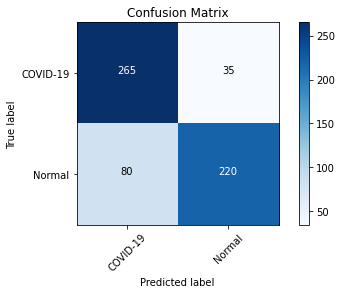

accuracy = 0.8083333333333333
recall = 0.7681159420289855
presition = 0.8833333333333333
specificity = 0.8627450980392157
f1 = 0.8217054263565893


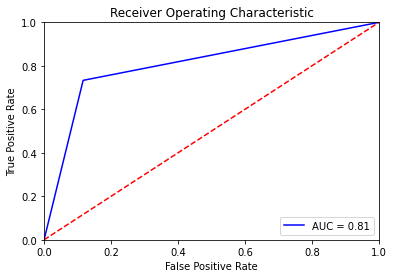

In [22]:
import sklearn.metrics as metrics

score(model,224)

In [23]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Rescale heatmap to a range 0-255
    img = img*255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap*0.4+img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))
    
    return superimposed_img
    
preprocess_input = tf.keras.applications.vgg16.preprocess_input
decode_predictions = tf.keras.applications.vgg16.decode_predictions

last_conv_layer_name = "block5_conv3"
img_size = (224,224)

# Remove last layer's softmax
model.layers[-1].activation = None

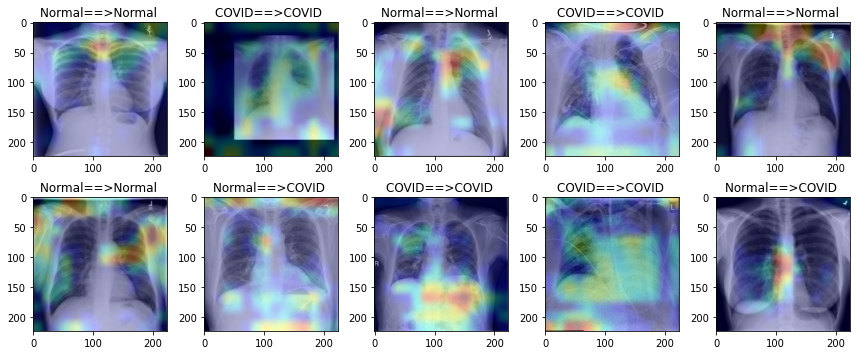

In [24]:
img_path = '/content/gdrive/MyDrive/data_set/test/COVID/COVID-58.png'
BS=8
from matplotlib import cm
plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    i=i+100
    array = np.expand_dims(X_test[i], axis=0)
    heatmap = make_gradcam_heatmap(array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(X_test[i], heatmap)
    plt.imshow(cam_path)
    predict = model.predict(X_test, batch_size=BS)
    predict = np.argmax(predict, axis=1)
    plt.title(f'{lb_encoder.inverse_transform(y_test.argmax(axis=1))[i]}==>{lb_encoder.inverse_transform(predict)[i]} ')
plt.tight_layout()
plt.show()



In [25]:
model.save('./vgg16.h5')